# More Analysis of NEEP Heat Pump Data

In [1]:
import math
import sys
import pandas as pd
import numpy as np

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [3]:
# Put the heat-pump-calc project in the path, so the library module
# can be accessed.
sys.path.insert(0, '../../heat-pump-calc')
import heatpump.library as library

In [4]:
dfht = library.df_heatpumps
dfht.head()

,brand,ahri_num,zones,outdoor_model,indoor_model,hspf,in_pwr_5F_max,capacity_5F_max,in_pwr_47F_min,cop_5F_max,cop_17F_max,cop_47F_max
0,Acd,202110483,Single,UHD09KCH38S-O,UHD09KCH38S-I,15.0,1.82,12977.0,0.20,2.089661,2.405652,2.657178
1,Acd,201863350,Single,OCD09KCH23S-O,OCD09KCH23S-I,10.5,1.33,9171.0,0.16,2.020868,2.183096,2.605076
2,Acd,202110500,Multi,MPD30KCH21S-O,Non-Ducted Indoor Units,11.5,3.01,19356.0,1.05,1.884613,3.126091,3.584757
3,Acd,202110494,Multi,MPD18KCH22S-O,Non-Ducted Indoor Units,11.0,2.30,13450.0,0.75,1.713829,2.415259,2.365502
4,Acd,202132789,Single,UHD24KCH22S-O,UHD24KCH22S-I,12.0,3.20,22553.0,0.38,2.065510,2.277197,2.534669


## Analyze Correlation between HSPF and COPs at Max Capacity

In [5]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Coefficients: 
 [-0.00819642]
Intercept: 2.49
Mean squared error: 0.12
R-squared: 0.001


Text(0, 0.5, 'COP at 17 F, Max Capacity')

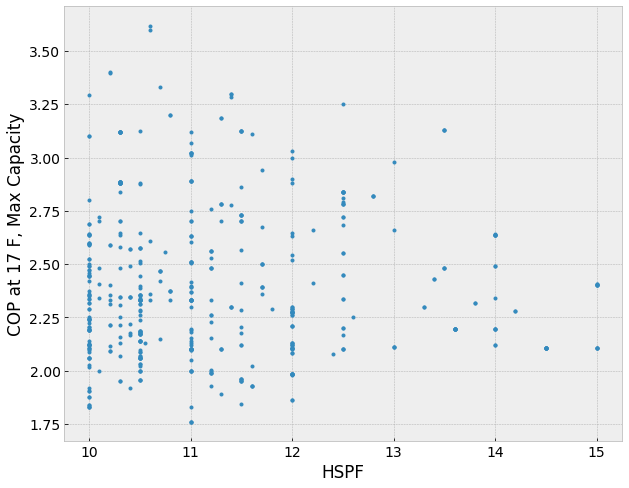

In [6]:
regr = linear_model.LinearRegression()
X = dfht[['hspf']]
y = dfht.cop_17F_max
regr.fit(X, y)

y_pred = regr.predict(X)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: %.2f' % regr.intercept_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y, y_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.3f' % r2_score(y, y_pred))
plot(X.hspf, y, '.')
xlabel('HSPF')
ylabel('COP at 17 F, Max Capacity')

### Look at Bins of HSPF and Plot COPs

Text(0.5, 0, 'HSPF')

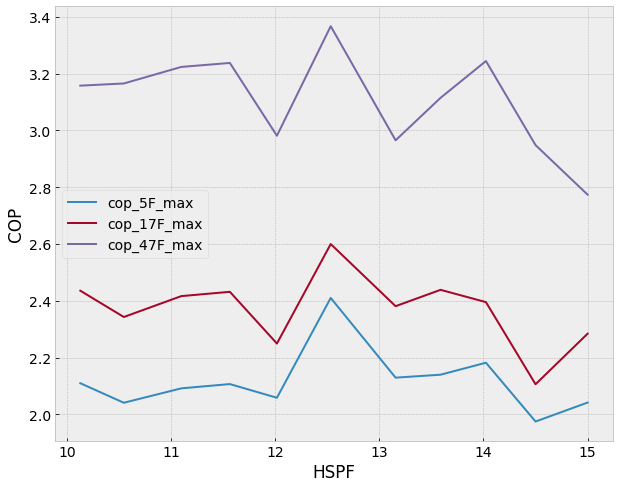

In [7]:
dfht['hspf_bin'] = dfht.hspf // 0.5
dfht_bin = dfht.groupby('hspf_bin').mean()
dfht_bin.drop(columns=['in_pwr_5F_max', 'capacity_5F_max', 'in_pwr_47F_min'], inplace=True)
dfht_bin.set_index('hspf', inplace=True)
dfht_bin.plot()
ylabel('COP')
xlabel('HSPF')

In [8]:
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

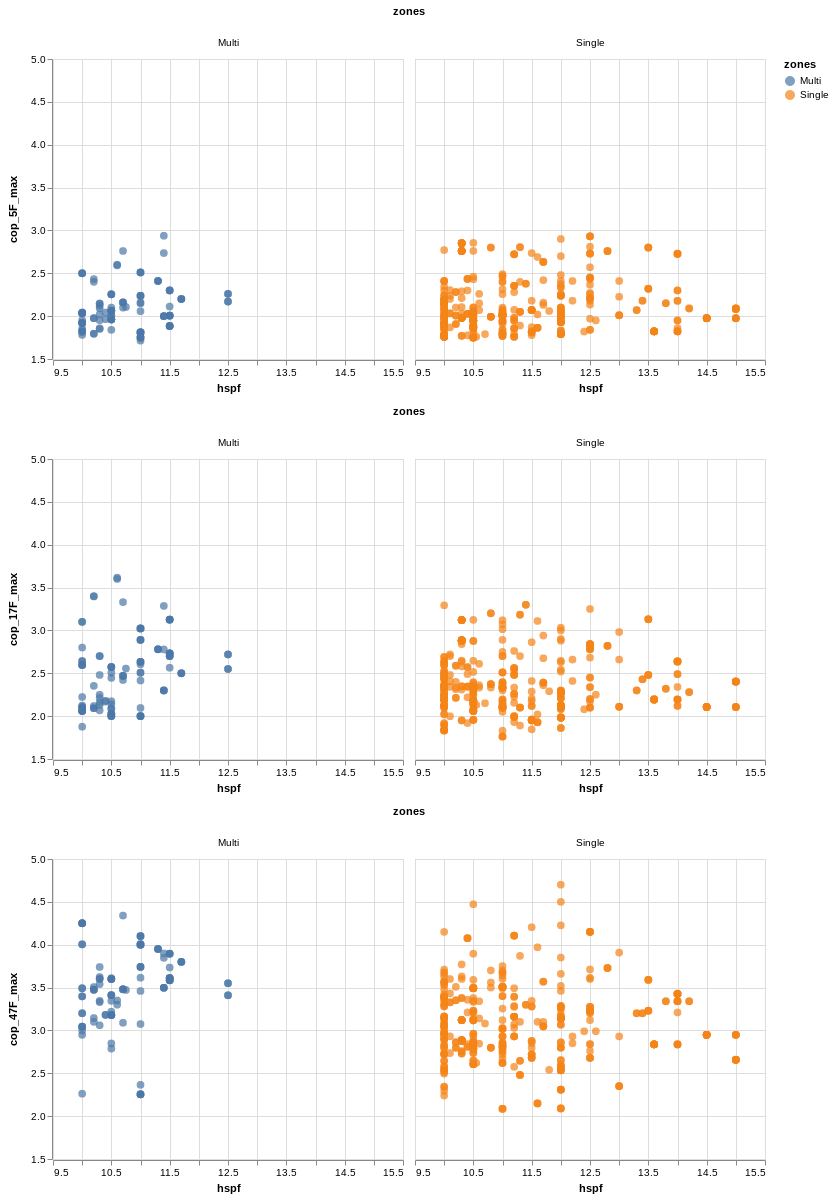

In [9]:
alt.Chart(dfht).mark_circle(size=60).encode(
    x=alt.X('hspf', type='quantitative', scale=alt.Scale(domain=[9.5, 15.5])),
    y=alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(domain=[1.5, 5])),
    color='zones',
    tooltip=['brand', 'outdoor_model']
).properties(
    width=350
).facet(
    column='zones:N'
).repeat(
    row=['cop_5F_max', 'cop_17F_max', 'cop_47F_max'],
).interactive()

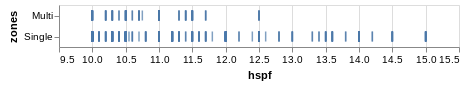

In [10]:
alt.Chart(dfht).mark_tick(size=10, thickness=1.5).encode(
    x=alt.X('hspf', scale=alt.Scale(domain=[9.5, 15.5])),
    y=alt.Y('zones'),
    tooltip=['brand', 'outdoor_model', 'indoor_model', 'hspf', 'capacity_5F_max']
).interactive()

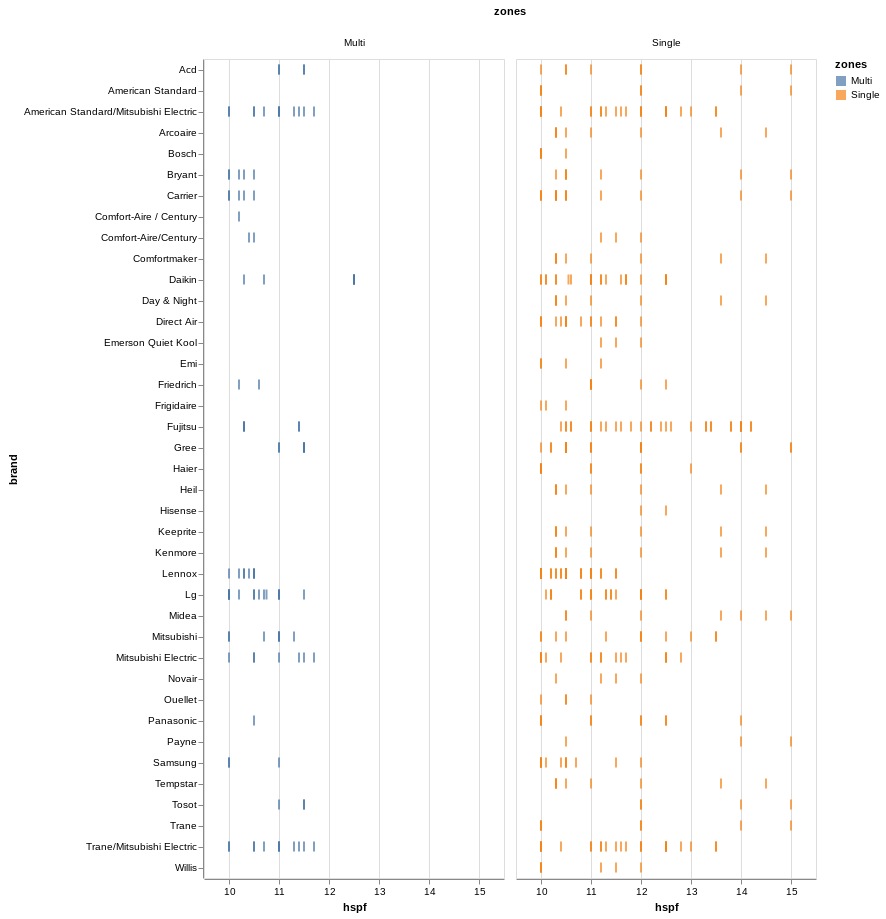

In [11]:
alt.Chart(dfht).mark_tick(size=10, thickness=2).encode(
    x=alt.X('hspf', scale=alt.Scale(domain=[9.5, 15.5])),
    y=alt.Y('brand'),
    color='zones',
    tooltip=['brand', 'outdoor_model', 'indoor_model', 'hspf', 'capacity_5F_max']
).properties(width=300).facet(column='zones').interactive()

In [12]:
dfht_grouped = dfht[['brand', 'zones', 'hspf']].groupby(['brand', 'zones'])
dfht_avg = dfht_grouped.agg([np.mean, np.min, np.max]).reset_index()
dfht_avg.columns = ['_'.join(col).strip().strip('_') for col in dfht_avg.columns.values]
dfht_avg.head()

,brand,zones,hspf_mean,hspf_amin,hspf_amax
0,Acd,Multi,11.250000,11.0,11.5
1,Acd,Single,11.875000,10.0,15.0
2,American Standard,Single,11.857143,10.0,15.0
3,American Standard/Mitsubishi Electric,Multi,10.883333,10.0,11.7
4,American Standard/Mitsubishi Electric,Single,11.654167,10.0,13.5


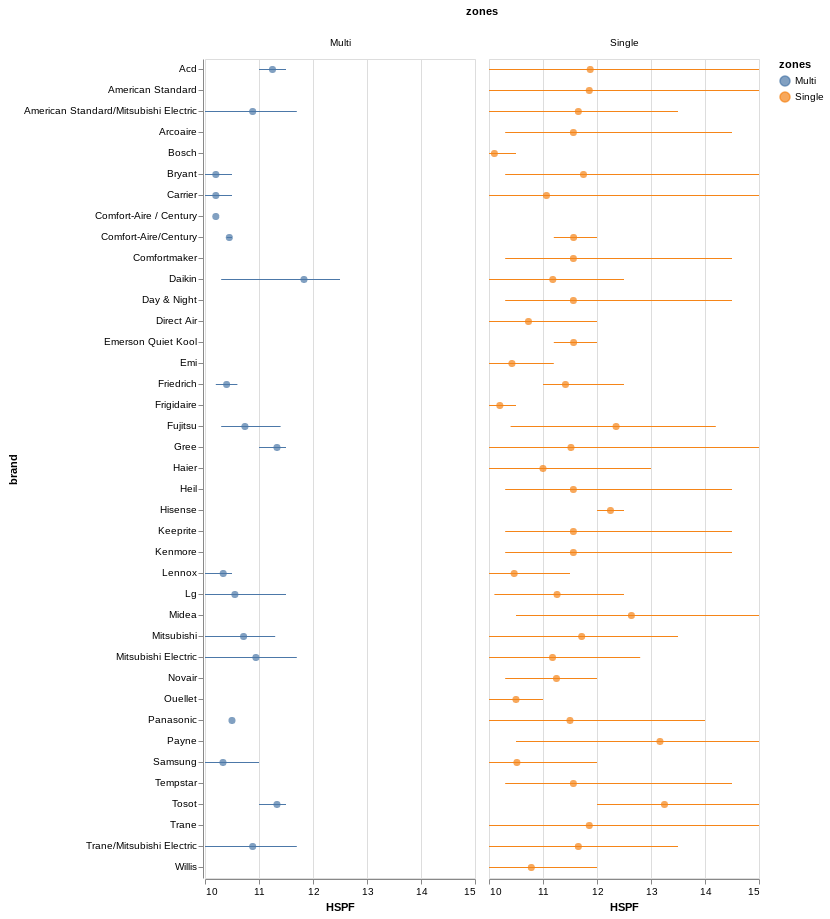

In [13]:
cht = alt.Chart().mark_circle(size=50, color='blue').encode(
    x=alt.X('hspf_mean', type='quantitative', 
            scale=alt.Scale(domain=[10., 15]),
            axis=alt.Axis(title='HSPF')),
    y=alt.Y('brand', type='nominal'),
    color='zones',
    tooltip=['brand', 'hspf_mean']
).properties(width=270)
cht += alt.Chart().mark_rule(color='blue').encode(
    x='hspf_amin:Q',
    x2='hspf_amax:Q',
    y='brand:N',
    color='zones',
).properties(width=270)
cht.facet(column='zones:N', data=dfht_avg)

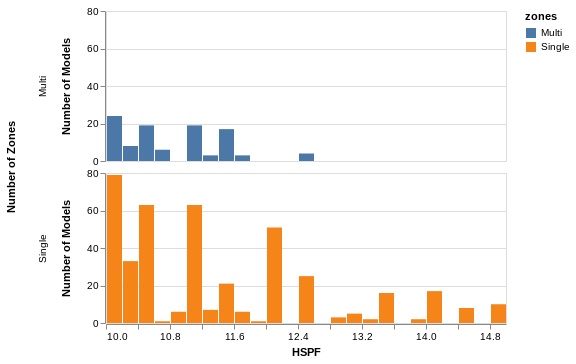

In [27]:
cht = alt.Chart(dfht, height=150).mark_bar().encode(
    alt.X('hspf', bin=alt.BinParams(maxbins=30), axis=alt.Axis(title='HSPF')),
    y=alt.Y('count(*):Q', axis=alt.Axis(title='Number of Models')),
    color='zones',
    row=alt.Row('zones', title='Number of Zones'),
)
cht.save('images/single_multi_hspf.png', scale_factor=1.5)
cht